<a href="https://colab.research.google.com/github/kawin-pixel/real_estate_th/blob/main/Real_estate_TH_200k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key summaries

# Gaps and further analysis


## Gaps
1.   Data for this analysis is solely sourced from www.ddproperty.com, potentially limiting its representation of the entire Thailand real estate market.
2.   Real estate transactions in rural areas may often be conducted offline, potentially leading to an overrepresentation of Bangkok in data that primarily tracks online activity.

## Further analysis
1. Cross-checking data from other source to gain clearer picture of the market

# Data preparation

In [1]:
install.packages("ggridges")
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(dbplyr)
library(ggplot2)
library(ggridges)
library(tidyverse)
library(ggrepel)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::ident()  masks dbplyr::ident()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::sql()    masks dbplyr::sql()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
data <- read.csv("/content/ddproperty_2022-04-19.csv")
##source: https://www.kaggle.com/datasets/polartech/200k-homes-for-sale-in-thailand

In [ ]:
summary(data)

 sub_property_type   agent_name         living_space     land_space_raw    
 Length:220557      Length:220557      Min.   :      1   Length:220557     
 Class :character   Class :character   1st Qu.:     35   Class :character  
 Mode  :character   Mode  :character   Median :     63   Mode  :character  
                                       Mean   :    393                     
                                       3rd Qu.:    150                     
                                       Max.   :6000000                     
                                       NA's   :32087                       
 price_per_unit       price_max         searched_field     bathroom_number 
 Length:220557      Min.   :0.000e+00   Length:220557      Min.   :  0.00  
 Class :character   1st Qu.:2.900e+06   Class :character   1st Qu.:  1.00  
 Mode  :character   Median :5.640e+06   Mode  :character   Median :  2.00  
                    Mean   :4.577e+07                      Mean   :  2.01  
            

In [4]:
## calculate price to sqm for condo
data <- data %>% mutate (price_sqm_condo = ifelse(data$property_type == "Condo", data$price / data$living_space, NA))

## categorise property by age
data$proprety_age_class <- case_when(
        data$built_year > 0 & data$built_year < 2014   ~ "10 year or more",
        data$built_year > 2014 ~ "Less than 10 yr",
        TRUE ~ NA_character_
        )
data$count <- 1 ## create count column

In [ ]:
summary(data)
tibble(data)
unique(data$property_type)
unique(data$state)
unique(data$proprety_age_class)
fivenum(data$price_sqm_condo)

#Condo analysis

## Condo price / sqm by district in BKK

## Aggregated data for BKK condos

In [5]:
#Aggregated data for BKK
d.condo_bkk <- data %>% filter(property_type == "Condo" & state == "Bangkok") %>% group_by(city) %>% summarise(
  avg_price = mean(price, na.rm = T),
  avg_sqm = mean(living_space, na.rm = T),
  total_count = sum(count)
  )

   d.condo_bkk <- d.condo_bkk %>% mutate(
    avg_price_sqm = avg_price/avg_sqm
  )

In [ ]:
 summary(d.condo_bkk)

     city             avg_price           avg_sqm        total_count     
 Length:50          Min.   :  941000   Min.   : 29.69   Min.   :    3.0  
 Class :character   1st Qu.: 2319946   1st Qu.: 39.41   1st Qu.:  108.2  
 Mode  :character   Median : 4044139   Median : 54.59   Median :  616.0  
                    Mean   : 6829303   Mean   :103.67   Mean   : 2160.5  
                    3rd Qu.: 8204447   3rd Qu.:101.48   3rd Qu.: 2664.2  
                    Max.   :40224172   Max.   :750.80   Max.   :20117.0  
 avg_price_sqm   
 Min.   :  3980  
 1st Qu.: 46175  
 Median : 72163  
 Mean   : 89242  
 3rd Qu.:107466  
 Max.   :427167  

Warning message:
“ggrepel: 33 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


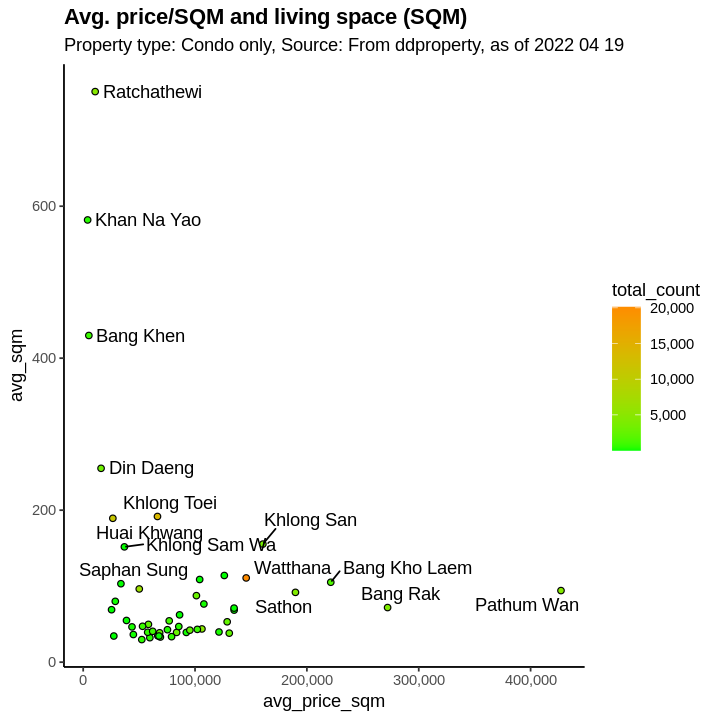

In [ ]:
## avg room size vs price / sqm
options(repr.plot.width=6, repr.plot.height=6, dpi = 600)

ggplot(d.condo_bkk, mapping = aes(x = avg_price_sqm, y = avg_sqm, label = city, fill = total_count)) +
  geom_point(shape = 21) +
  scale_y_continuous(labels = scales::comma) +
  scale_x_continuous(labels = scales::comma) +
  geom_text_repel() +
   scale_fill_gradient(high = "darkorange", low = "green",
                      labels = scales::comma) +

  ## theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "Avg. price/SQM and living space (SQM)",
        subtitle = "Property type: Condo only, Source: From ddproperty, as of 2022 04 19")

Warning message:
“Removed 6532 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


95% 
290400

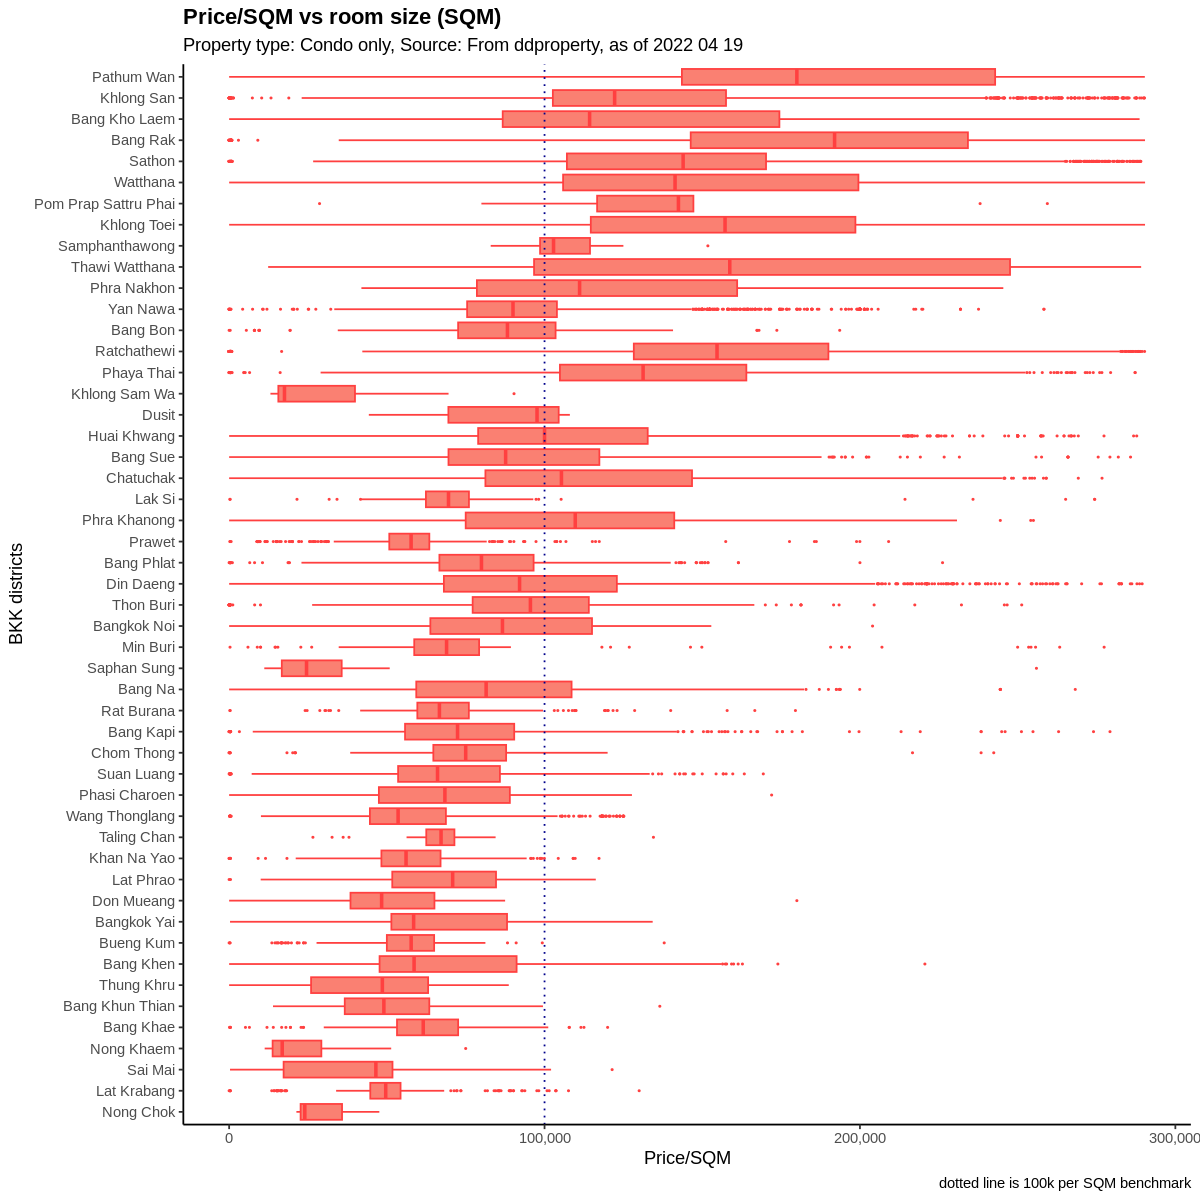

In [ ]:
#supply overview

##condo price / sqm by district in BKK
options(repr.plot.width=10, repr.plot.height=10, dpi = 600)

ggplot(subset(data, property_type == "Condo" & state == "Bangkok" ),
mapping = aes(x = price_sqm_condo, y = reorder(city, price))) +
  geom_boxplot( fill = "salmon", outlier.size = 0.2, col = "brown1") +
  scale_x_continuous(limits = c(0,290400), ##price quantile 0.95 = 290,400
                     labels = scales::comma) +
 geom_vline(xintercept = 100000, color = "darkblue",  linetype = "dotted") +

  ## theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "Price/SQM vs room size (SQM)",
        subtitle = "Property type: Condo only, Source: From ddproperty, as of 2022 04 19 ",
        caption ="dotted line is 100k per SQM benchmark",
        y = "BKK districts",
        x = "Price/SQM")


quantile(data$price_sqm_condo, 0.95, na.rm = T)

In [ ]:
str(data)

'data.frame':	220557 obs. of  72 variables:
 $ sub_property_type      : chr  "For Sale" "For Sale" "For Sale" "For Sale" ...
 $ agent_name             : chr  "คุณโบว์ 095-405-8716" "Nakornthong Property" "Nakornthong Property" "Pichai.So" ...
 $ living_space           : num  280 NA NA 35 28 37 36 23 NA NA ...
 $ land_space_raw         : chr  "271.2 sqm" "328 sqm" "328 sqm" "" ...
 $ price_per_unit         : chr  "฿84623.8938 / sqm" "฿48780.4878 / sqm" "฿48780.4878 / sqm" "฿62857.1429 / sqm" ...
 $ price_max              : num  2.3e+07 1.6e+07 1.6e+07 2.2e+06 1.5e+06 ...
 $ searched_field         : chr  "TH1001_2_1.html" "TH1001_2_1.html" "TH1001_2_1.html" "TH1001_2_1.html" ...
 $ bathroom_number        : int  NA NA NA 1 1 1 1 1 NA NA ...
 $ property_status        : chr  "ACT" "ACT" "ACT" "ACT" ...
 $ search_date            : logi  NA NA NA NA NA NA ...
 $ ad_type                : logi  NA NA NA NA NA NA ...
 $ currency               : chr  "Baht" "Baht" "Baht" "Baht" ...
 $ apartment_n

Picking joint bandwidth of 7820

Warning message:
“Removed 6532 rows containing non-finite outside the scale range
(`stat_density_ridges()`).”


95% 
290400

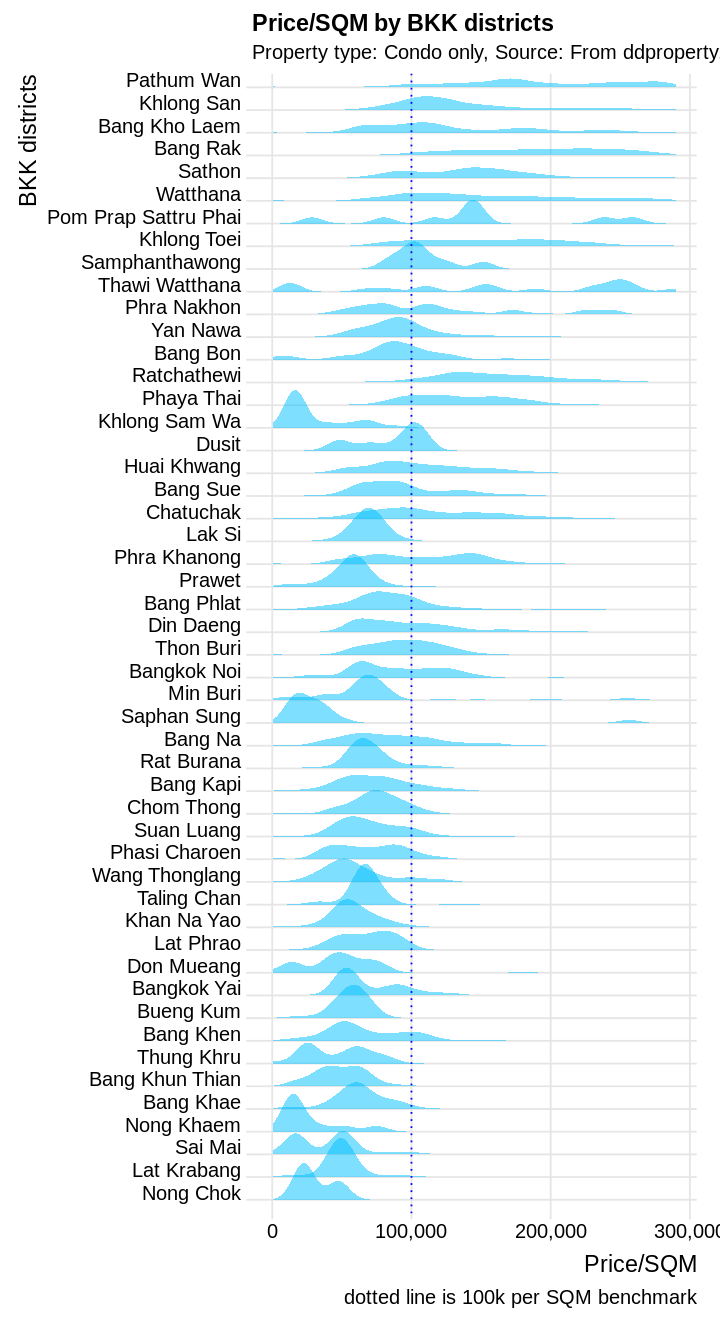

In [ ]:
##test ridgeline chart

#supply overview

##condo price / sqm by district in BKK
options(repr.plot.width=6, repr.plot.height=11, dpi = 600)

ggplot(subset(data, property_type == "Condo" & state == "Bangkok" ),
mapping = aes(x = price_sqm_condo, y = reorder(city, price))) +
  geom_density_ridges(fill = "deepskyblue1", alpha = 0.5, color = NA) +
  scale_x_continuous(limits = c(0,290400), ##price quantile 0.95 = 290,400
                     labels = scales::comma) +
 geom_vline(xintercept = 100000, color = "Blue",  linetype = "dotted") +

  ## theme and label
  theme_ridges() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "Price/SQM by BKK districts",
        subtitle = "Property type: Condo only, Source: From ddproperty, as of 2022 04 19 ",
        caption ="dotted line is 100k per SQM benchmark",
        y = "BKK districts",
        x = "Price/SQM")


quantile(data$price_sqm_condo, 0.95, na.rm = T)

95% 
59900000

Picking joint bandwidth of 648000

Warning message:
“Removed 36799 rows containing non-finite outside the scale range
(`stat_density_ridges()`).”


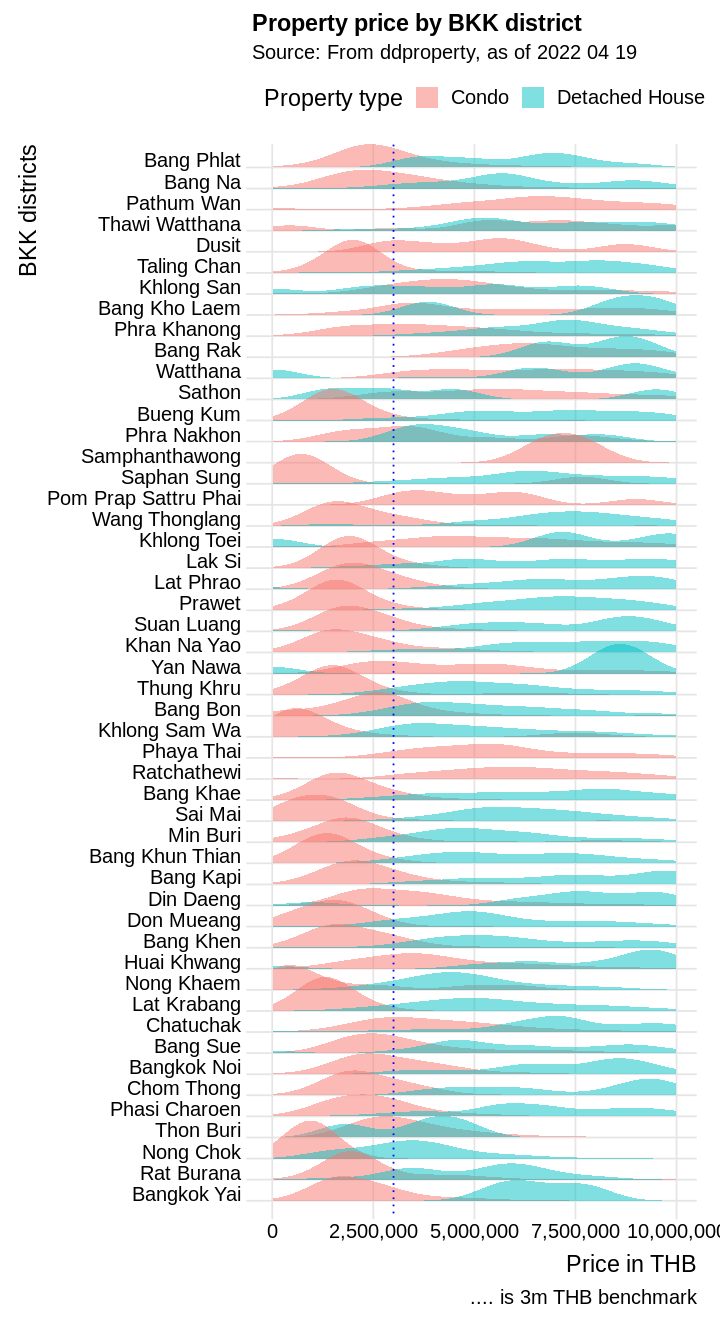

In [ ]:
##condo, detached house, townhouse in BKK
options(repr.plot.width=6, repr.plot.height=11, dpi = 600)

quantile(subset(data$price, data$state == "Bangkok"),0.95, na.rm = T) ##calculate 0.95 quantile of property price in BKK
#59,900,000

ggplot(subset(data,property_type != "Land" & property_type != "Apartment" & property_type != "Townhouse"
& state == "Bangkok"), mapping = aes(x = price, y = reorder(city, price), fill = property_type)) +
  geom_density_ridges(alpha = 0.5, color = NA) +
  scale_x_continuous(limits = c(0,10000000), ##zoom in 1-10m to see insight
                     labels = scales::comma) +
   geom_vline(xintercept = 3000000, color = "Blue",  linetype = "dotted") +

  ## theme and label
  theme_ridges() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans"),
        legend.position = "top") +
  labs(title = "Property price by BKK district",
        subtitle = "Source: From ddproperty, as of 2022 04 19 ",
        y = "BKK districts",
        caption = ".... is 3m THB benchmark",
        fill = "Property type",
        x = "Price in THB")

Picking joint bandwidth of 6900000

Picking joint bandwidth of 672000

Picking joint bandwidth of 3250000

Picking joint bandwidth of 5150000

Picking joint bandwidth of 1200000

Warning message:
“Removed 6883 rows containing non-finite outside the scale range
(`stat_density_ridges()`).”


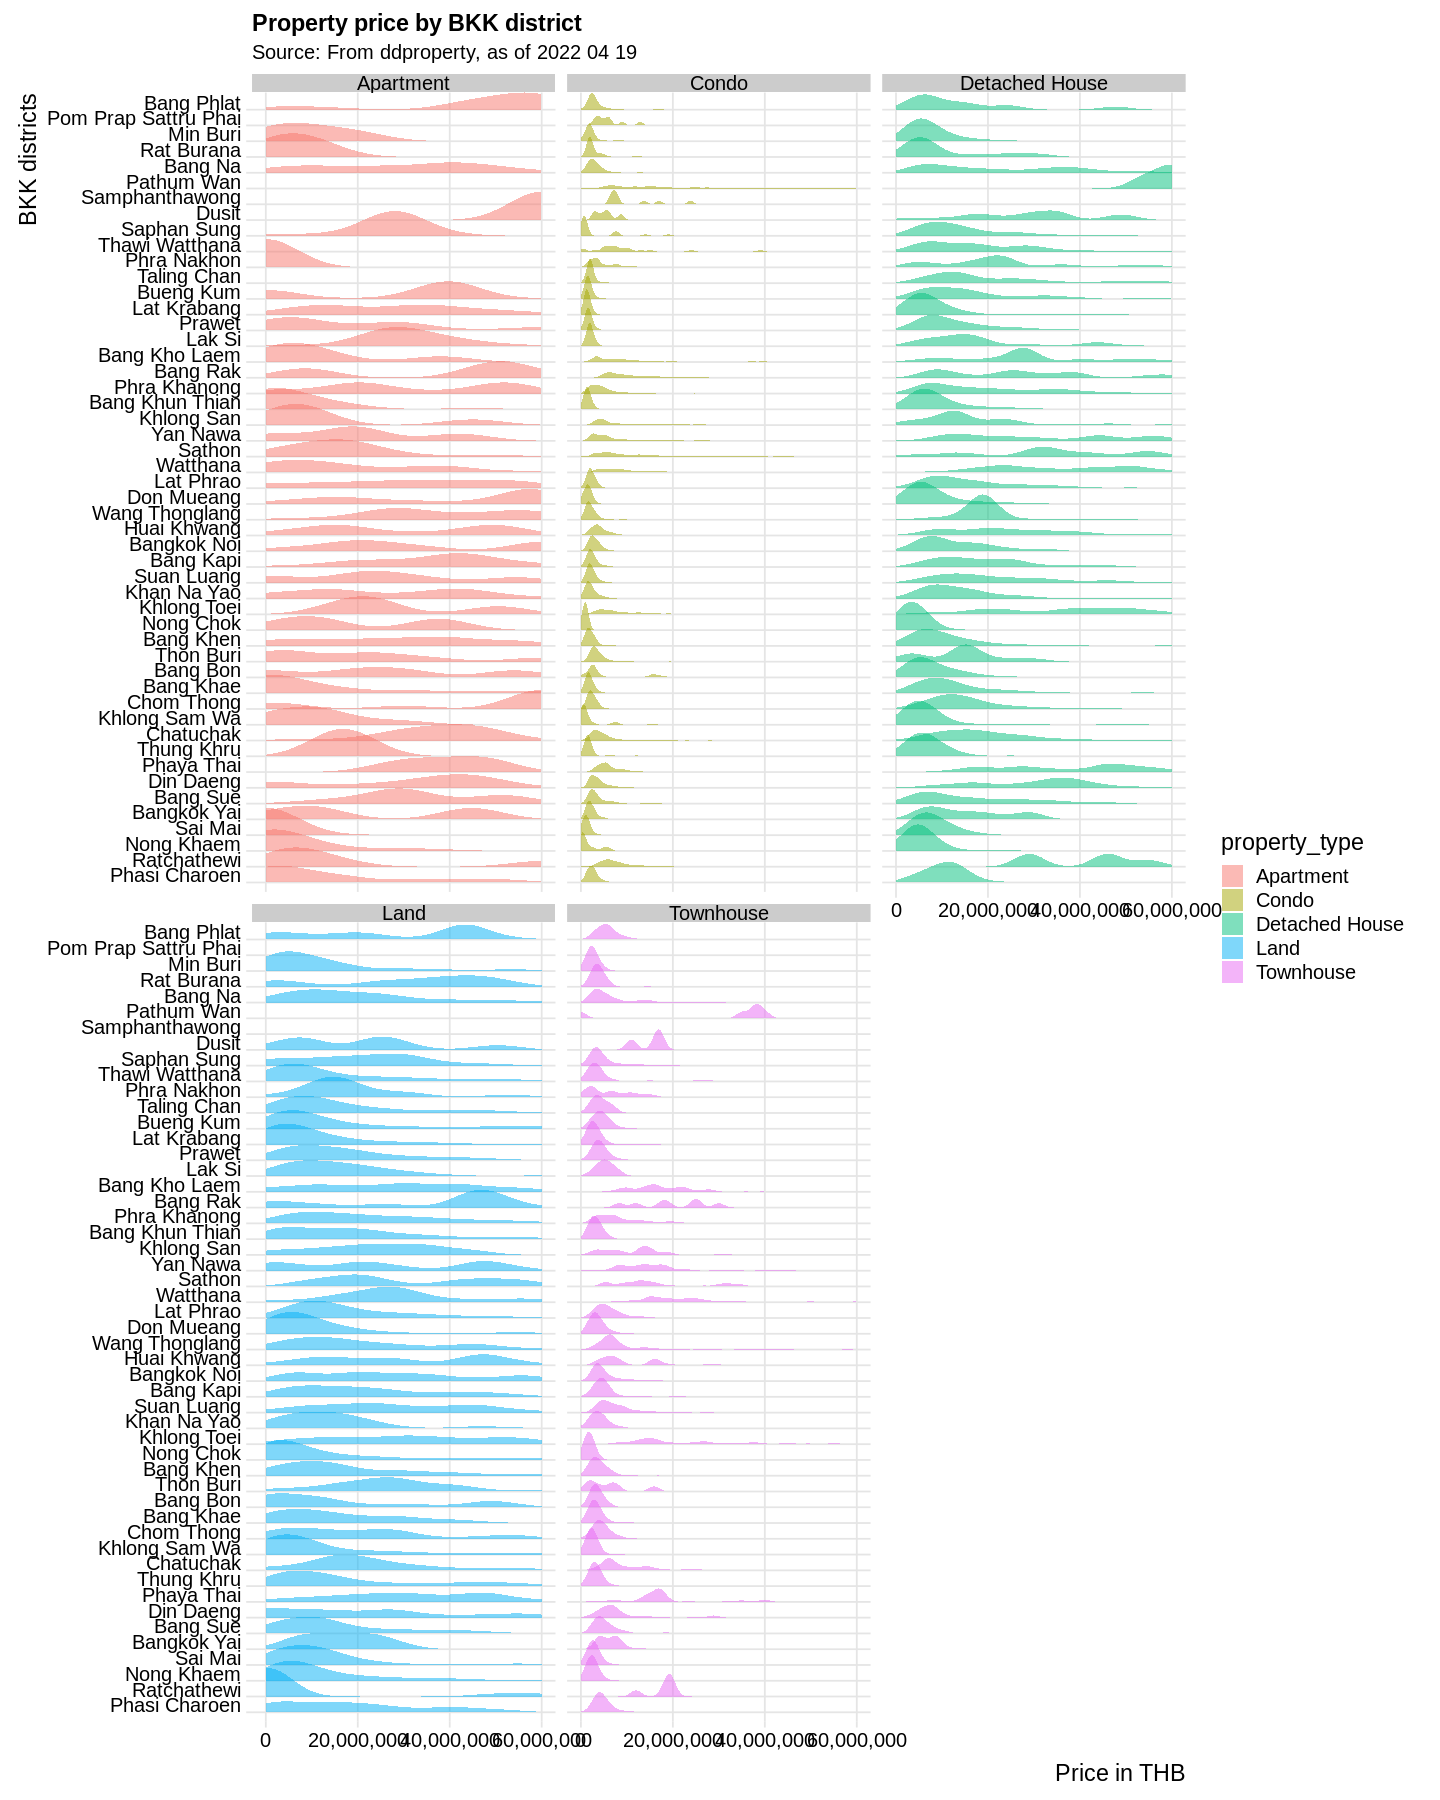

In [ ]:
##facet wrap all property type
options(repr.plot.width=12, repr.plot.height=15, dpi = 600)

#quantile(subset(data$price, data$state == "Bangkok"),0.95, na.rm = T) ##calculate 0.95 quantile of property price in BKK
#59,900,000

ggplot(subset(data, state == "Bangkok"),
mapping = aes(x = price, y = reorder(city, price), fill = property_type)) +
  geom_density_ridges(alpha = 0.5, color = NA) +
  scale_x_continuous(limits = c(0,60000000), ##price quantile 0.95 = 290,400
                     labels = scales::comma) +
 facet_wrap(~ property_type) +

  ## theme and label
  theme_ridges() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "Property price by BKK district",
        subtitle = "Source: From ddproperty, as of 2022 04 19 ",
        y = "BKK districts",
        x = "Price in THB")

## Condo price / sqm in BKK

Warning message:
“Removed 6816 rows containing missing values or values outside the scale range
(`geom_point()`).”


95% 
290400

95% 
475

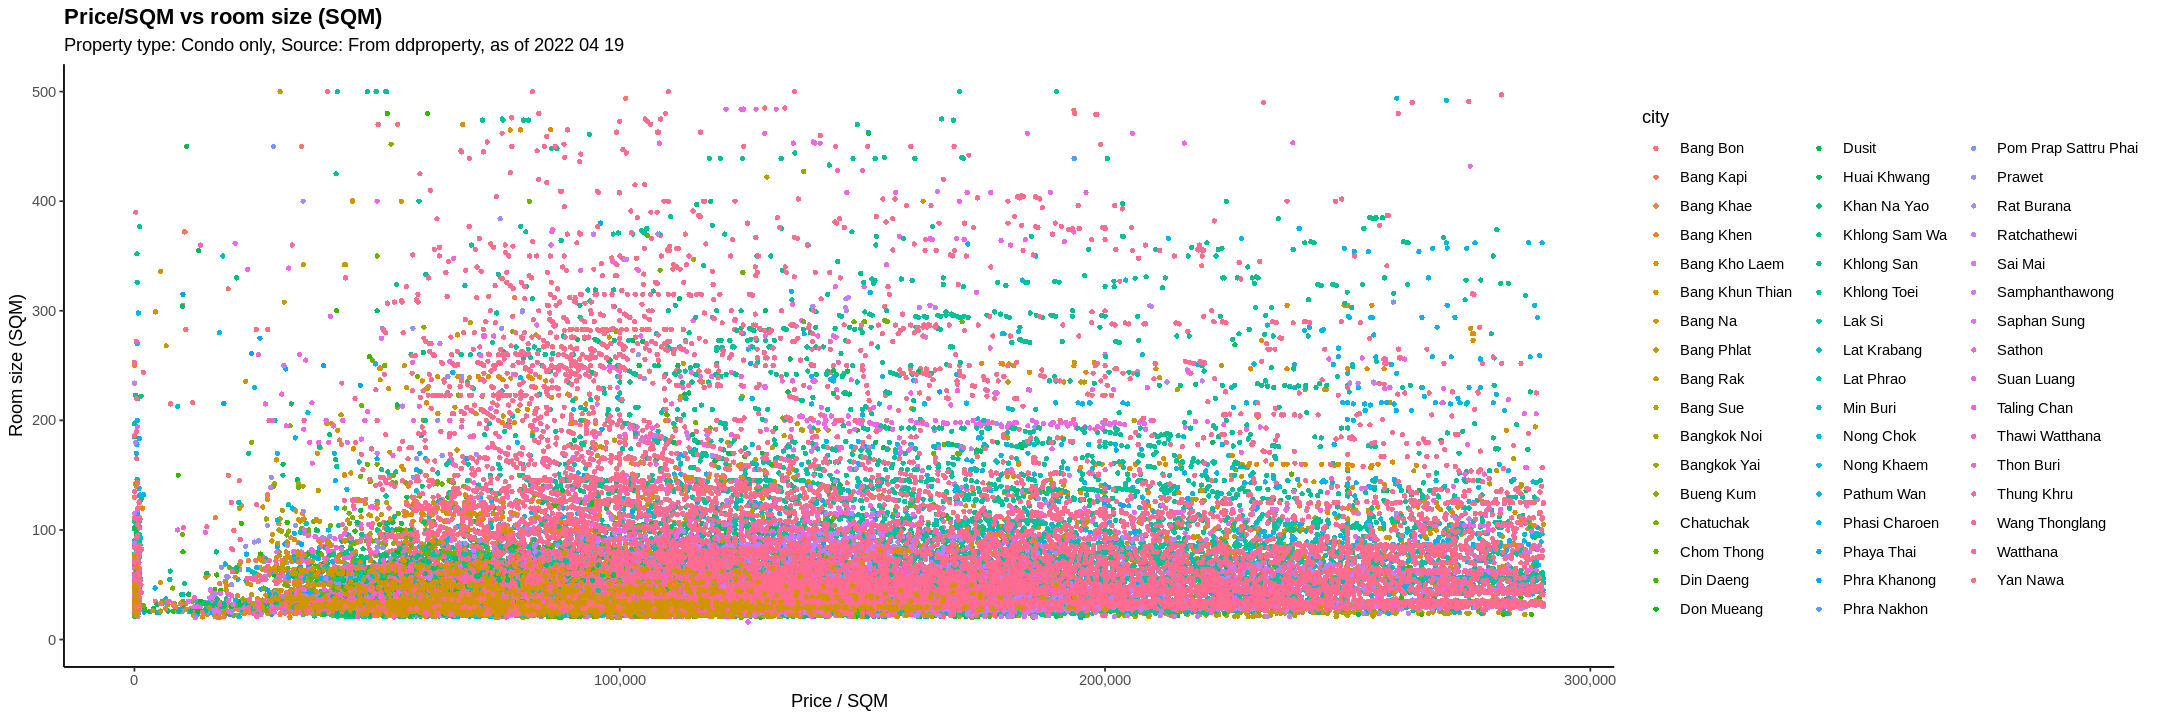

In [ ]:
options(repr.plot.width=18, repr.plot.height=6, dpi = 600)

##condo price / sqm in BKK
ggplot(subset(data, property_type == "Condo" & state == "Bangkok" ), mapping = aes(x = price_sqm_condo, y = living_space,
                                                                                   fill = city)) +
  geom_point(shape = 21,
              stroke = NA) +
  scale_x_continuous(limits = c(0,290400), ##price quantile 0.95 = 290,400
                     labels = scales::comma) +
  scale_y_continuous(limits = c(0,500), ##living space quantile 0.95 = 475
                     labels = scales::comma) +
  ## theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs( x = "Price / SQM",
        y = "Room size (SQM)",
        title = "Price/SQM vs room size (SQM)",
        subtitle = "Property type: Condo only, Source: From ddproperty, as of 2022 04 19 ")

quantile(data$price_sqm_condo, 0.95, na.rm = T)
quantile(data$living_space, 0.95, na.rm = T)

##Room size vs price breakdown by BKK district

In [ ]:
quantile(data$price_sqm_condo, 0.98, na.rm = T)
#362,727

98% 
362727.3

Warning message:
“Removed 2759 rows containing missing values or values outside the scale range
(`geom_point()`).”


90% 
234042.6

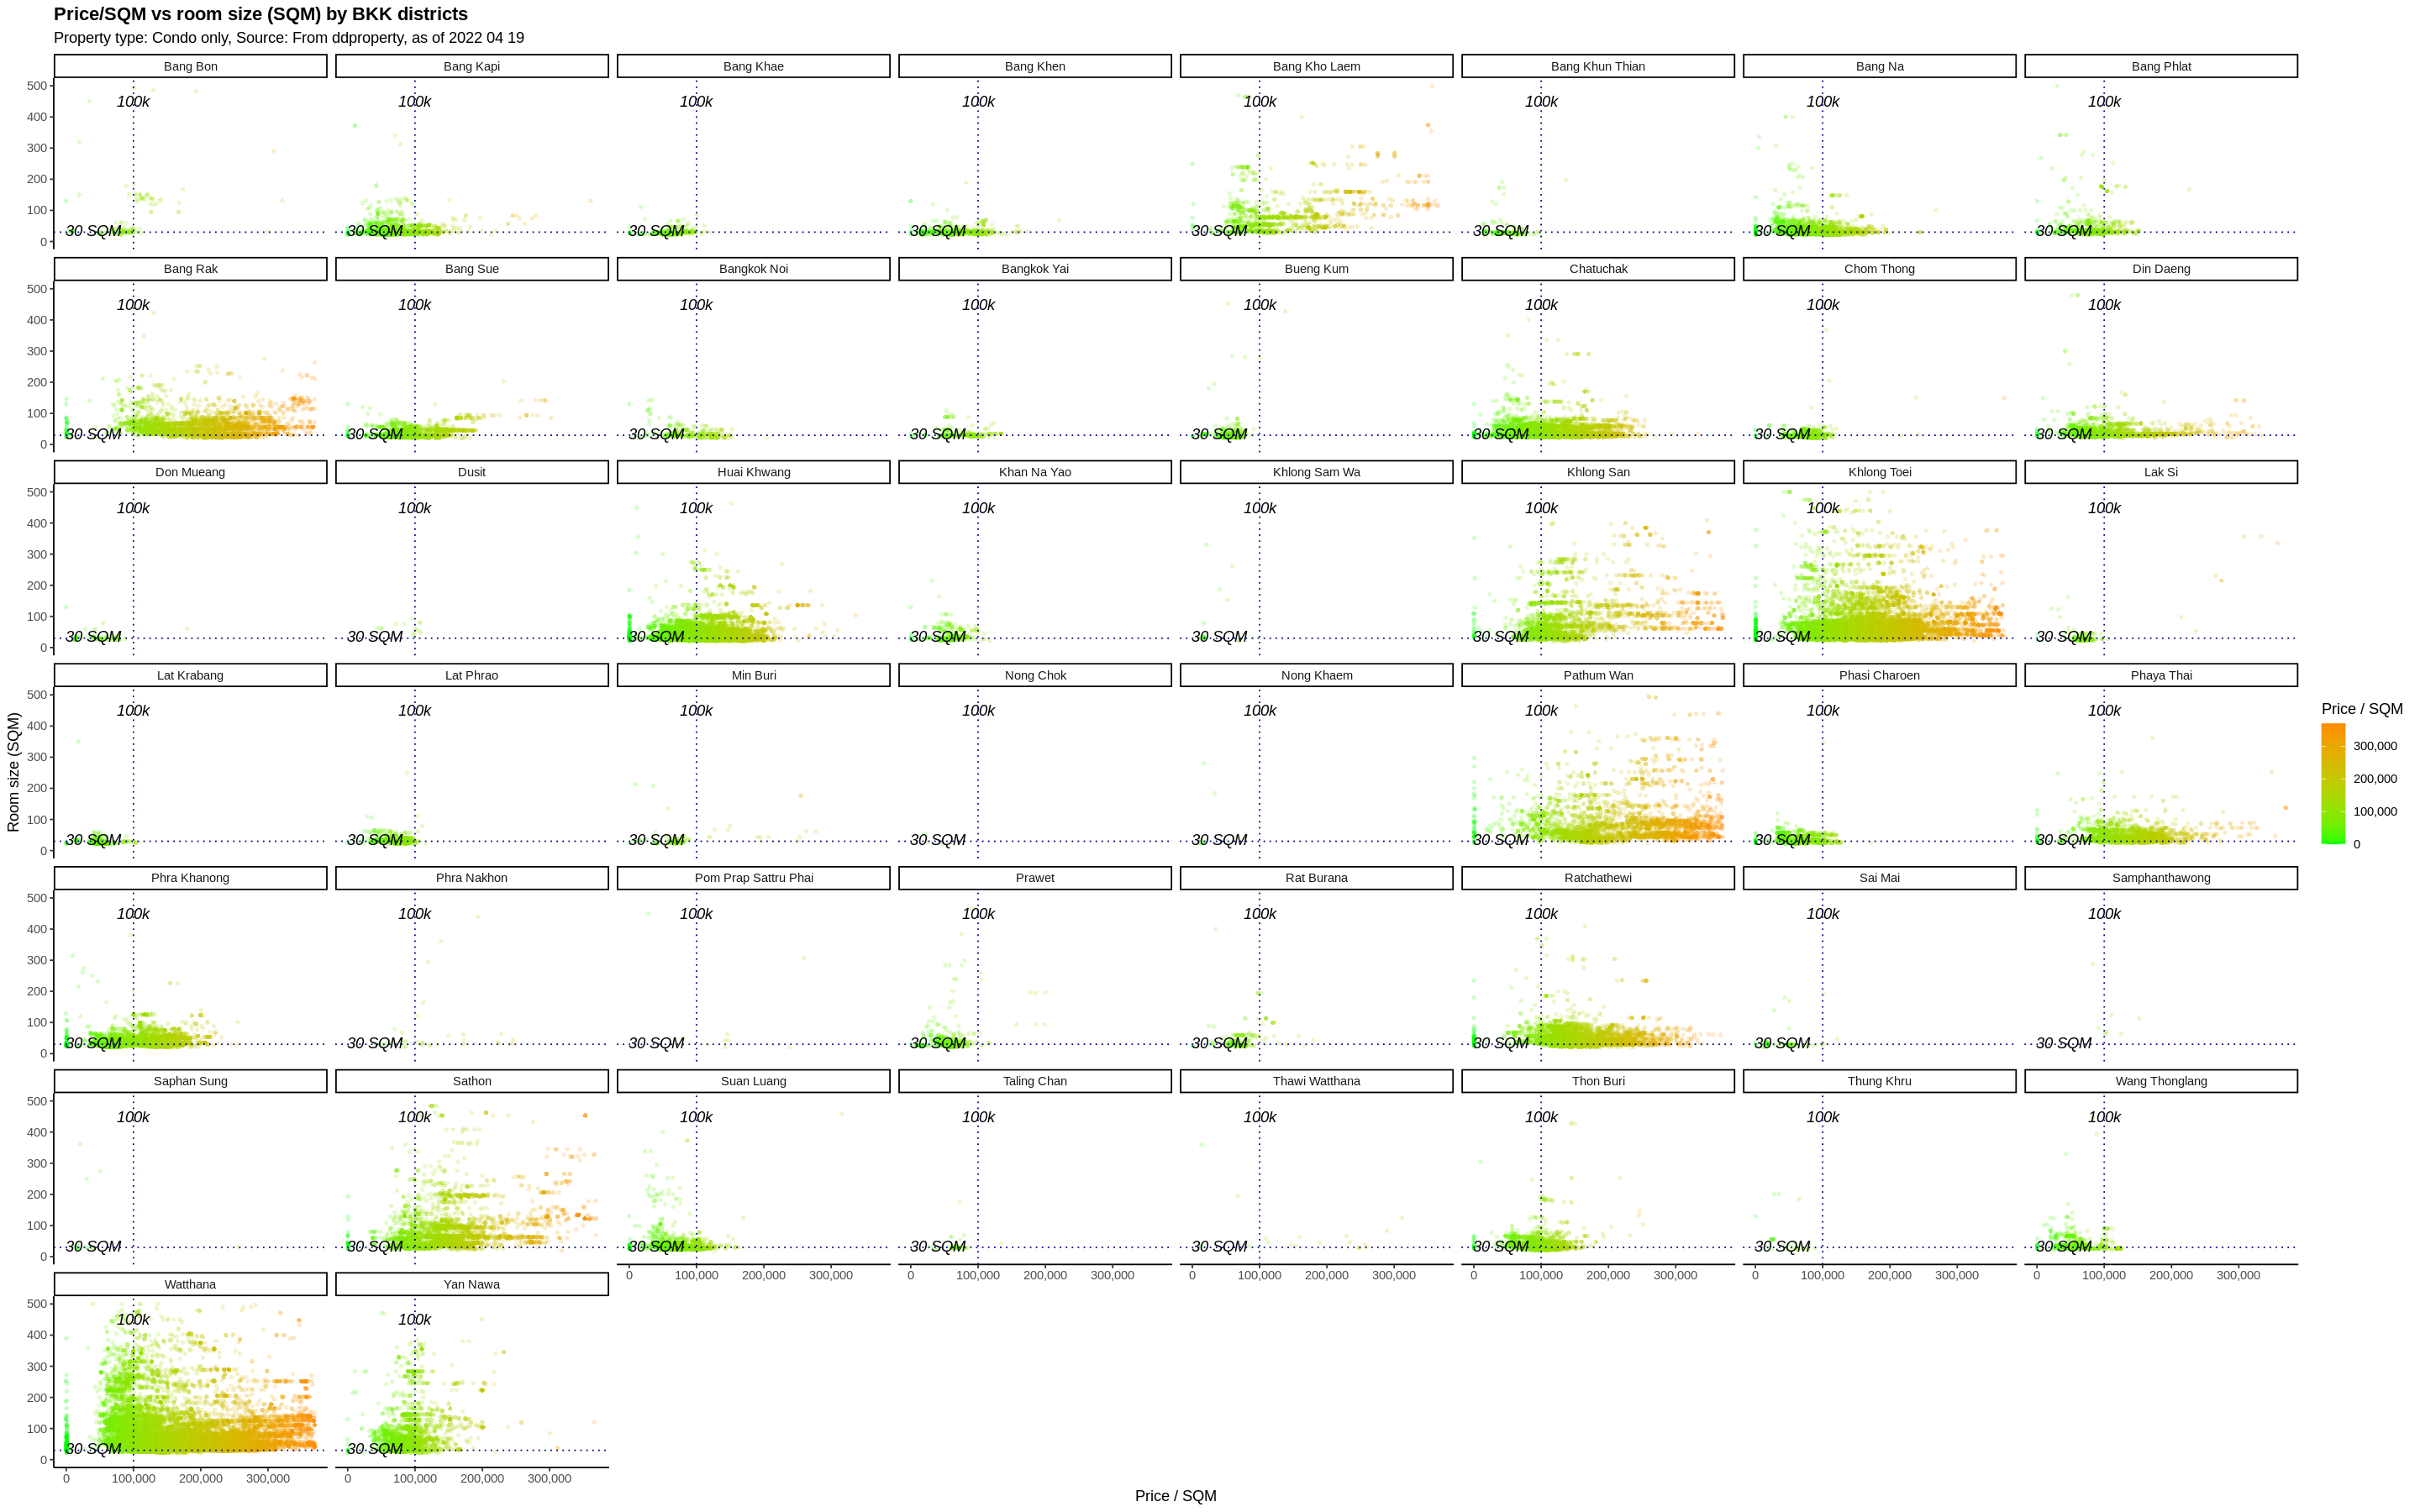

In [ ]:
options(repr.plot.width=24, repr.plot.height=15, dpi = 600)

##condo price / sqm in BKK
ggplot(subset(data, property_type == "Condo" & state == "Bangkok" ), mapping = aes(x = price_sqm_condo, y = living_space,
                                                                                   fill = price_sqm_condo)) +
  geom_point(shape = 21, stroke = NA, alpha = 0.2) +
  scale_x_continuous(limits = c(0,370000), ##price quantile 0.99 = 362,727
                     labels = scales::comma) +
  scale_y_continuous(limits = c(0,500), ##living space quantile 0.95 = 475
                     labels = scales::comma) +

  geom_hline(yintercept = 30, color = "darkblue",  linetype = "dotted") +
  annotate ("text", x = 100000, y = 450, label = "100k", fontface = "italic") +

  geom_vline(xintercept = 100000, color = "darkblue",  linetype = "dotted") +
  annotate ("text", x = 40000, y = 35, label = "30 SQM", fontface = "italic") +

  scale_fill_gradient(high = "darkorange", low = "green",
                      limits = c(0,370000),
                      labels = scales::comma) +
  facet_wrap(~ city) +
  ## theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs( x = "Price / SQM",
        y = "Room size (SQM)",
        fill = "Price / SQM",
        title = "Price/SQM vs room size (SQM) by BKK districts",
        subtitle = "Property type: Condo only, Source: From ddproperty, as of 2022 04 19 ")
quantile(data$price_sqm_condo, 0.90, na.rm = T)

## About Condo age

In [ ]:
options(repr.plot.width=24, repr.plot.height=15, dpi = 600)

##condo price / sqm in BKK
ggplot(subset(data, property_type == "Condo" & state == "Bangkok" ), mapping = aes(x = price_sqm_condo, y = living_space,
                                                                                   fill = built_year)) +
  geom_point(shape = 21, stroke = NA, alpha = 1) +
  scale_x_continuous(limits = c(0,290400), ##price quantile 0.95 = 290,400
                     labels = scales::comma) +
  scale_y_continuous(limits = c(0,500), ##living space quantile 0.95 = 475
                     labels = scales::comma) +

  geom_hline(yintercept = 30, color = "darkblue",  linetype = "dotted") +
  annotate ("text", x = 100000, y = 450, label = "100k", fontface = "italic") +

  geom_vline(xintercept = 100000, color = "darkblue",  linetype = "dotted") +
  annotate ("text", x = 40000, y = 35, label = "30 SQM", fontface = "italic") +

  scale_fill_gradient(high = "darkorange", low = "blue",
                      limits = c(1994,2025))+

  facet_wrap(~ city) +
  ## theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs( x = "Price / SQM",
        y = "Room size (SQM)",
        fill = "Year built",
        title = "Price/SQM vs room size (SQM) by BKK districts and year built",
        subtitle = "Property type: Condo only, Source: From ddproperty, as of 2022 04 19 ")
quantile(data$price_sqm_condo, 0.90, na.rm = T)

ERROR: Error: object 'property_type' not found


In [ ]:
quantile(data$built_year, 0, na.rm = T)

0% 
1971

Warning message:
“Removed 2759 rows containing missing values or values outside the scale range
(`geom_point()`).”


90% 
234042.6

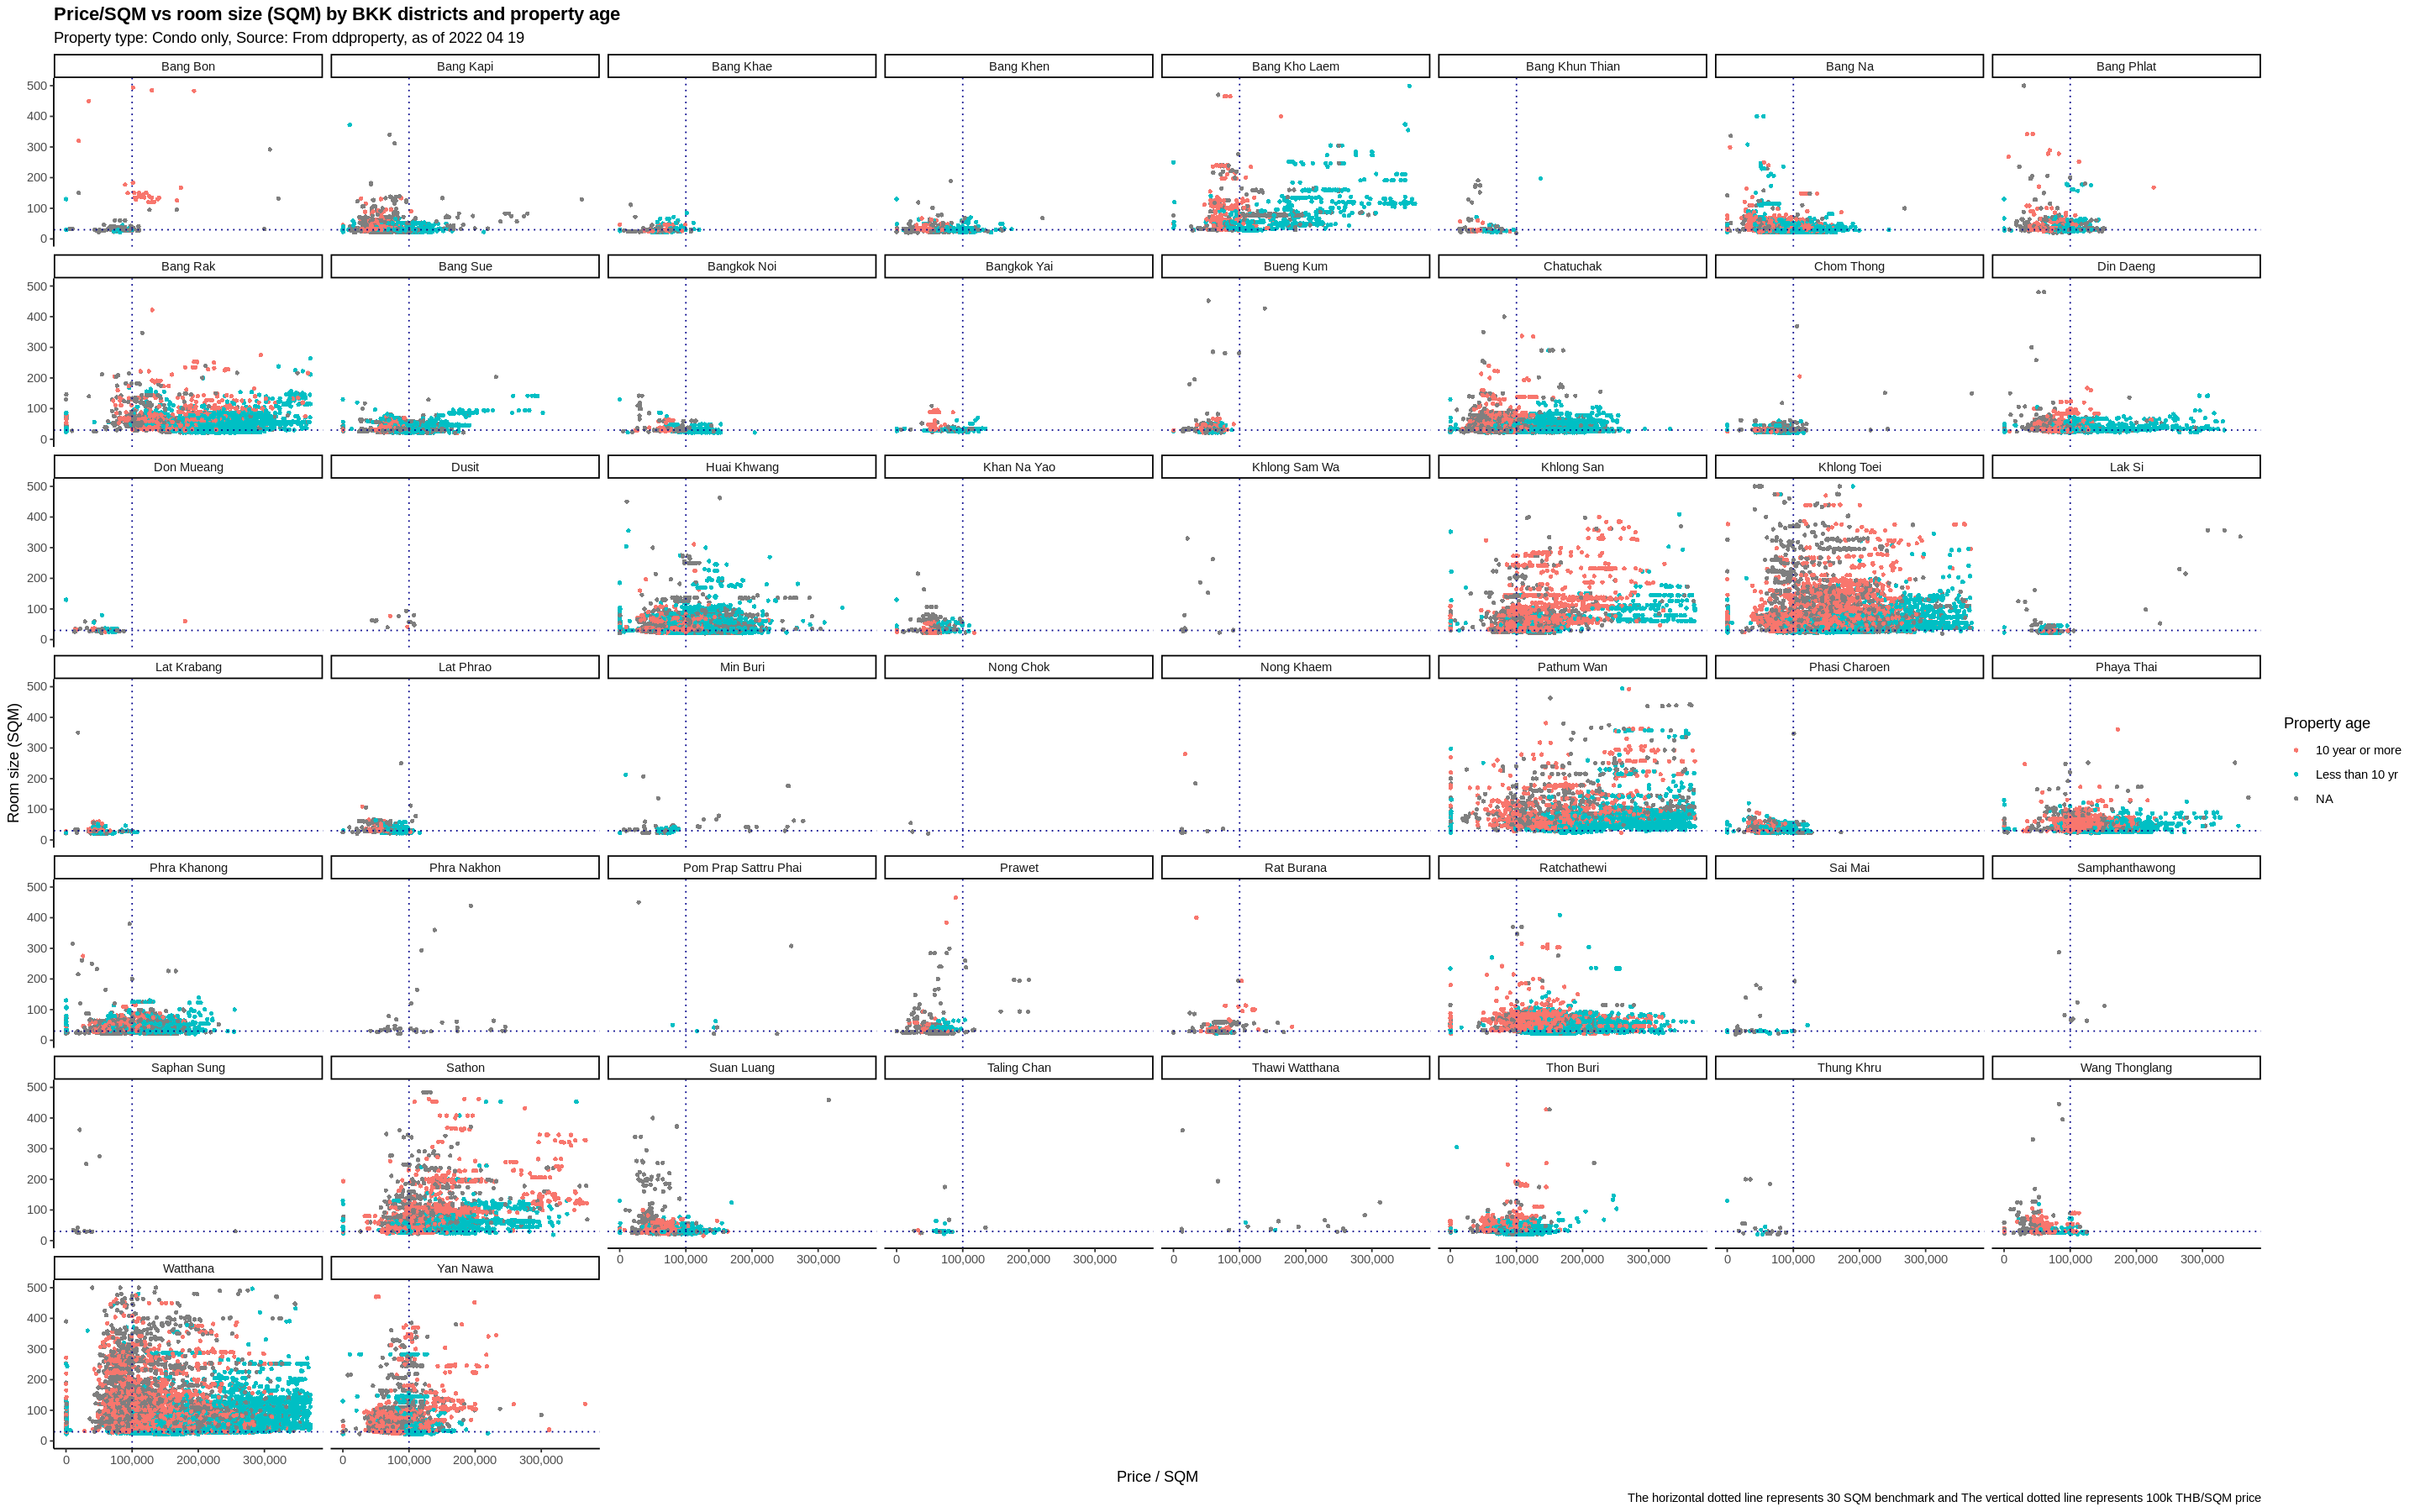

In [6]:
options(repr.plot.width=24, repr.plot.height=15, dpi = 600)

##condo price / sqm in BKK
ggplot(subset(data, property_type == "Condo" & state == "Bangkok" ), mapping = aes(x = price_sqm_condo, y = living_space,
                                                                                   fill = proprety_age_class)) +
  geom_point(shape = 21, stroke = NA, alpha = 1) +
  scale_x_continuous(limits = c(0,370000), ##price quantile 0.95 = 370,000
                     labels = scales::comma) +
  scale_y_continuous(limits = c(0,500), ##living space quantile 0.95 = 475
                     labels = scales::comma) +

  geom_hline(yintercept = 30, color = "darkblue",  linetype = "dotted") +
  geom_vline(xintercept = 100000, color = "darkblue",  linetype = "dotted") +

  facet_wrap(~ city) +
  ## theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs( x = "Price / SQM",
        y = "Room size (SQM)",
        fill = "Property age",
        title = "Price/SQM vs room size (SQM) by BKK districts and property age",
        subtitle = "Property type: Condo only, Source: From ddproperty, as of 2022 04 19 ",
        caption = "The horizontal dotted line represents 30 SQM benchmark and The vertical dotted line represents 100k THB/SQM price")
quantile(data$price_sqm_condo, 0.90, na.rm = T)

In [ ]:
options(repr.plot.width=24, repr.plot.height=15, dpi = 600)

##condo price / sqm in BKK
ggplot(subset(data, property_type == "Condo" & state == "Bangkok" ), mapping = aes(x = price_sqm_condo, y = city,
                                                                                   fill = proprety_age_class)) +
  geom_col( position = "fill") +
  scale_x_continuous(labels = scales::comma) +

  ## theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs( title = "Price/SQM vs room size (SQM) by BKK districts",
        subtitle = "Property type: Condo only, Source: From ddproperty, as of 2022 04 19 ")
quantile(data$price_sqm_condo, 0.90, na.rm = T)

# All property types

Warning message:
“Removed 10278 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


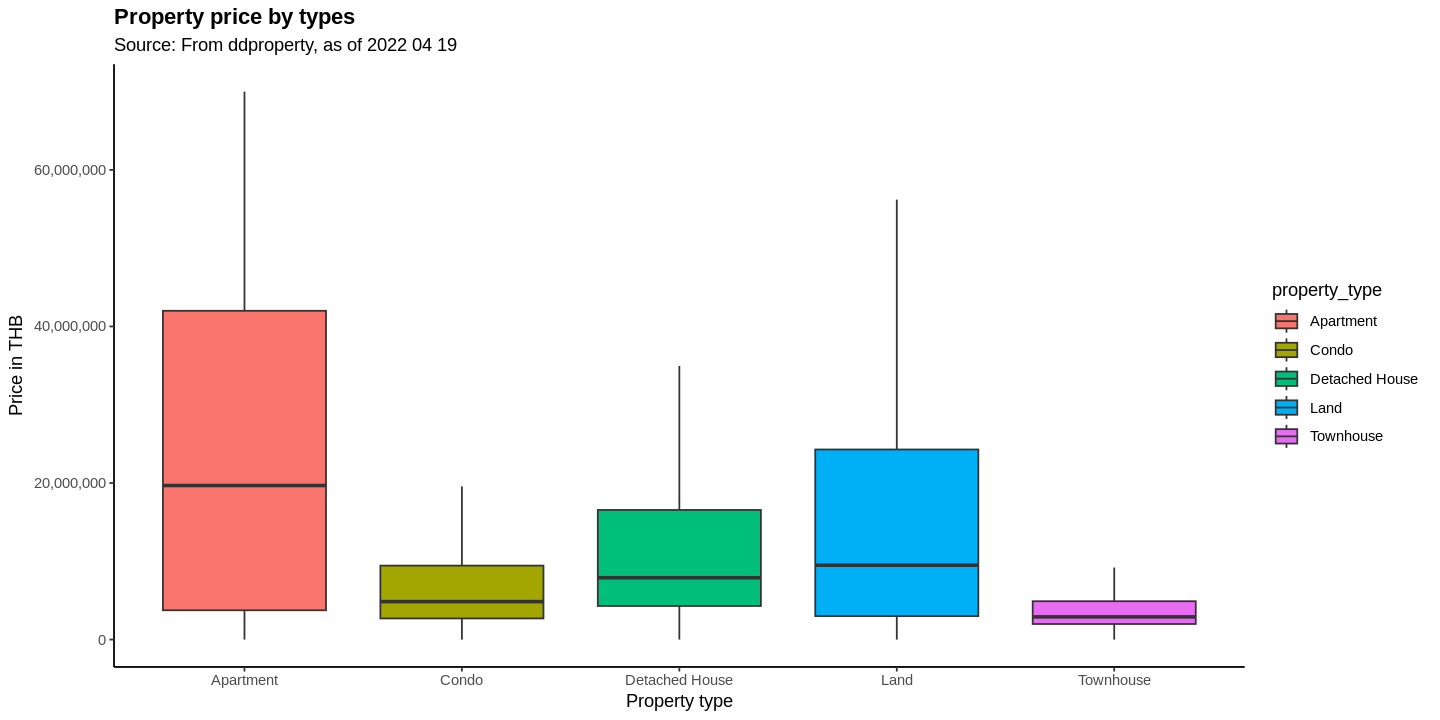

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 6, dpi = 600)

ggplot(data, mapping = aes(y = price, x = property_type, fill = property_type)) +
  geom_boxplot(outlier.shape = NA) +
  scale_y_continuous(limits = c(0,70000000), ##price quantile 0.95 = 67m THB
                     labels = scales::comma) +

##theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs( x = "Property type",
        y = "Price in THB",
        title = "Property price by types",
        subtitle = "Source: From ddproperty, as of 2022 04 19 ")

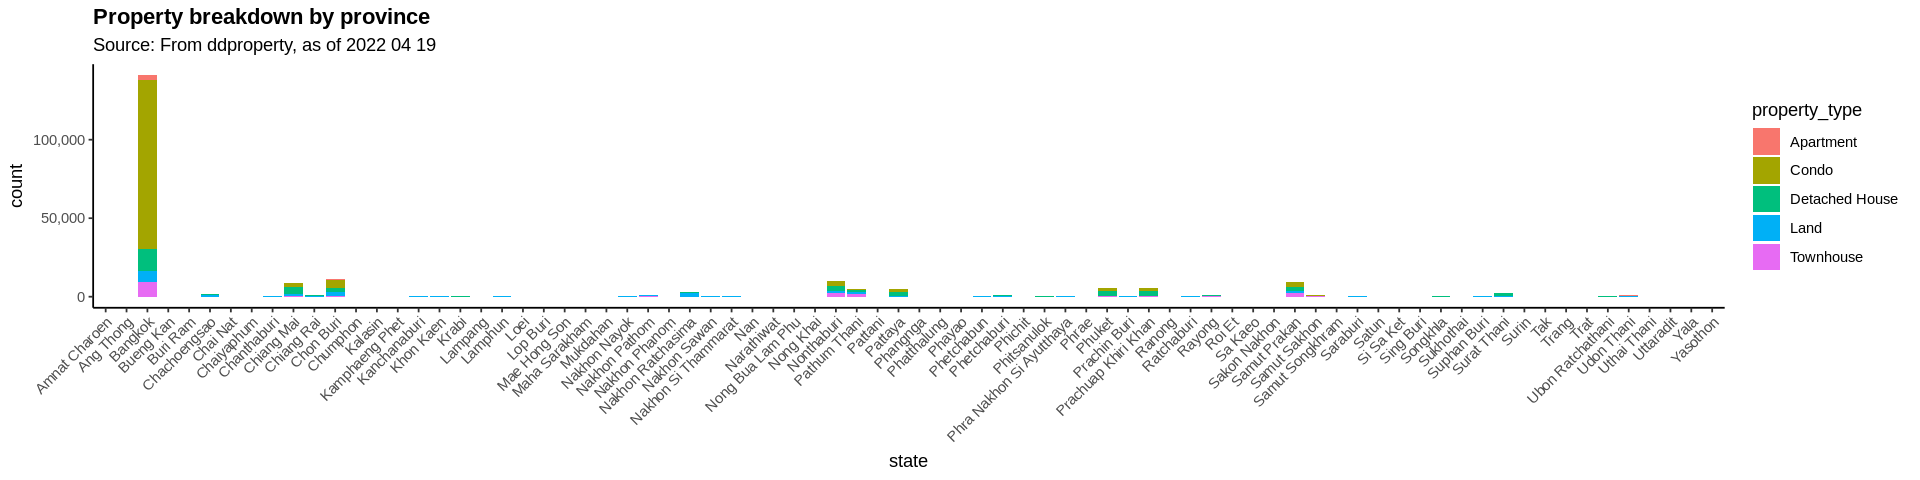

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 4, dpi = 600)

ggplot(data, mapping = aes(y = state, fill = property_type)) +
  geom_bar() +
  scale_x_continuous(labels = scales::comma) +
  coord_flip() +

##theme and label
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs( title = "Property breakdown by province",
        subtitle = "Source: From ddproperty, as of 2022 04 19 ")

# For-sell market overtime

In [ ]:
# For-sell market overtime

## create new date column
data <- data %>% mutate(
  new_updated_date = as.Date(data$last_updated)
)

head(data$new_updated_date,10)

d.by_date <- data %>% group_by (new_updated_date) %>%
  summarise(total_count = sum(count), total_price = sum(price))

head(d.by_date)

new_updated_date,total_count,total_price
<date>,<dbl>,<dbl>
2022-01-26,2,9280000
2022-02-22,1,312300000
2022-02-24,1,1380000
2022-02-28,1,3190000
2022-03-01,2,7406100
2022-03-04,2,16980000


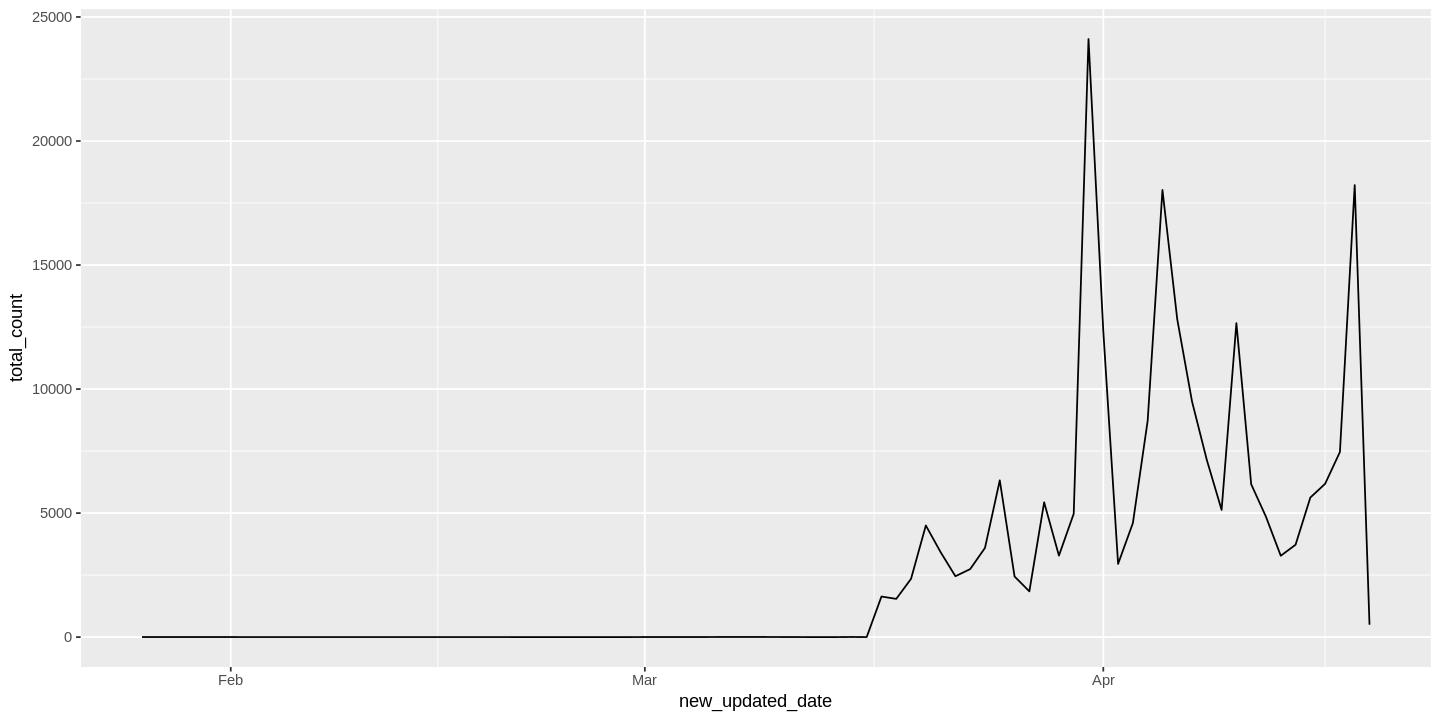

In [ ]:
ggplot(d.by_date, mapping = aes(x = new_updated_date, y = total_count)) +
  geom_line()

#Agregated data by state

In [ ]:
##Aggregated data by state

d.by_State <- data %>%
  group_by(state, property_type) %>%
  summarise(
    total_price = sum(price),
    total_count = sum(count),
  )

`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.


## No. of selling property by state

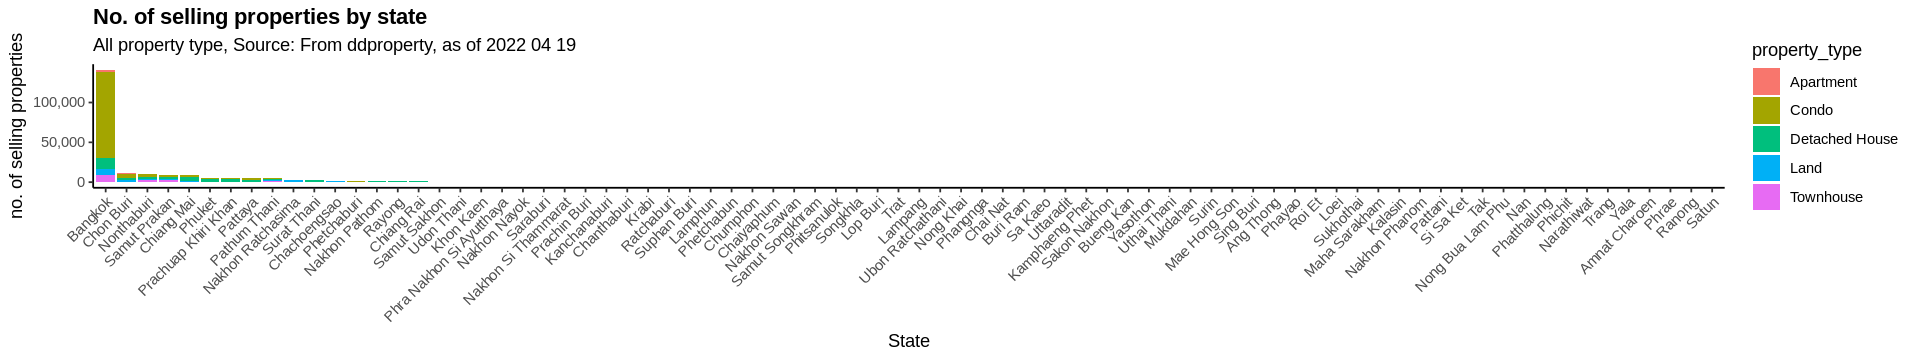

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 3, dpi = 600)

## No. of selling property by state
ggplot(d.by_State, mapping = aes(y = reorder(state, -total_count), x = total_count, fill = property_type)) +
  geom_col() +
  scale_x_continuous(labels = scales::comma) +
  coord_flip() +
  ##theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "No. of selling properties by state",
       y = "State",
       x = "no. of selling properties",
       subtitle = "All property type, Source: From ddproperty, as of 2022 04 19 ")

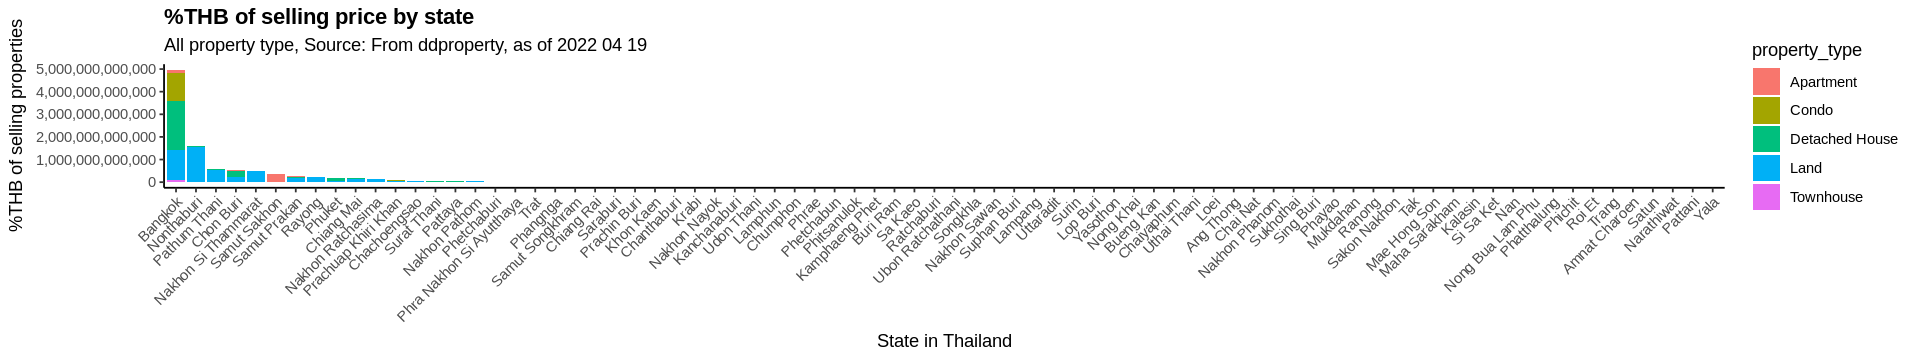

In [ ]:
## THB of selling price by state
ggplot(d.by_State, mapping = aes(y = reorder(state, -total_price), x = total_price, fill = property_type)) +
  geom_col() +
  scale_x_continuous(labels = scales::comma) +
  coord_flip() +
  ##theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "%THB of selling price by state",
       y = "State in Thailand",
       x = "%THB of selling properties",
       subtitle = "All property type, Source: From ddproperty, as of 2022 04 19 ")

## % of selling property by state

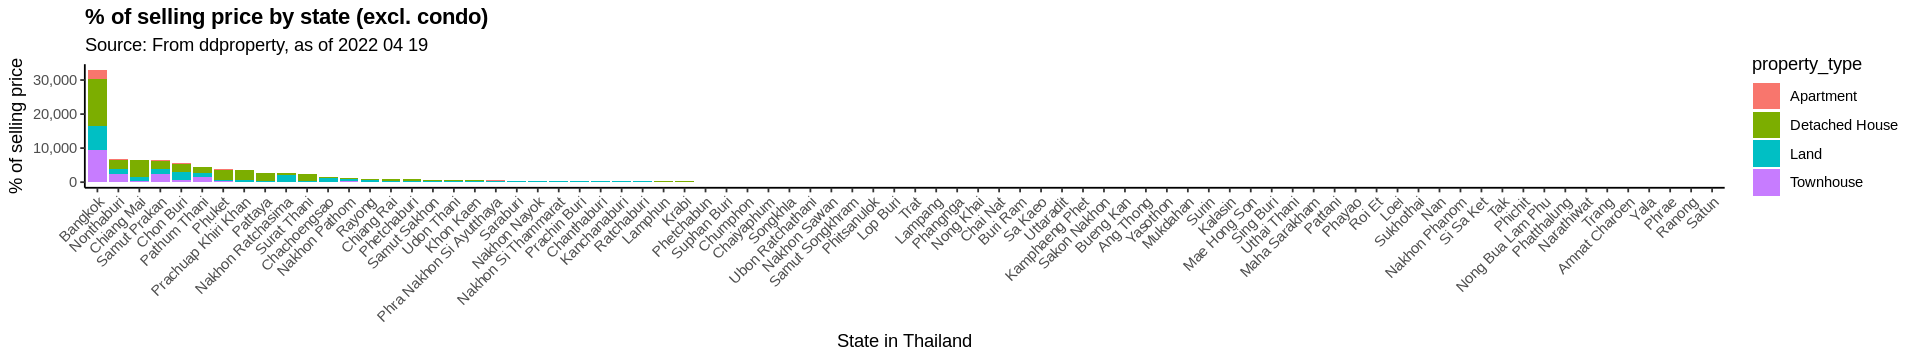

In [ ]:
## No. of selling property by state (excl. condo) (Coord_flip)

ggplot(subset(d.by_State, property_type != "Condo" ) ,mapping = aes(y = reorder(state, -total_count),
                                                      x = total_count, fill = property_type)) +
  geom_col() +
  scale_x_continuous(labels = scales::comma) +
  coord_flip() +
  ##theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "% of selling price by state (excl. condo)",
       x = "% of selling price",
       y = "State in Thailand",
       subtitle = "Source: From ddproperty, as of 2022 04 19 ")

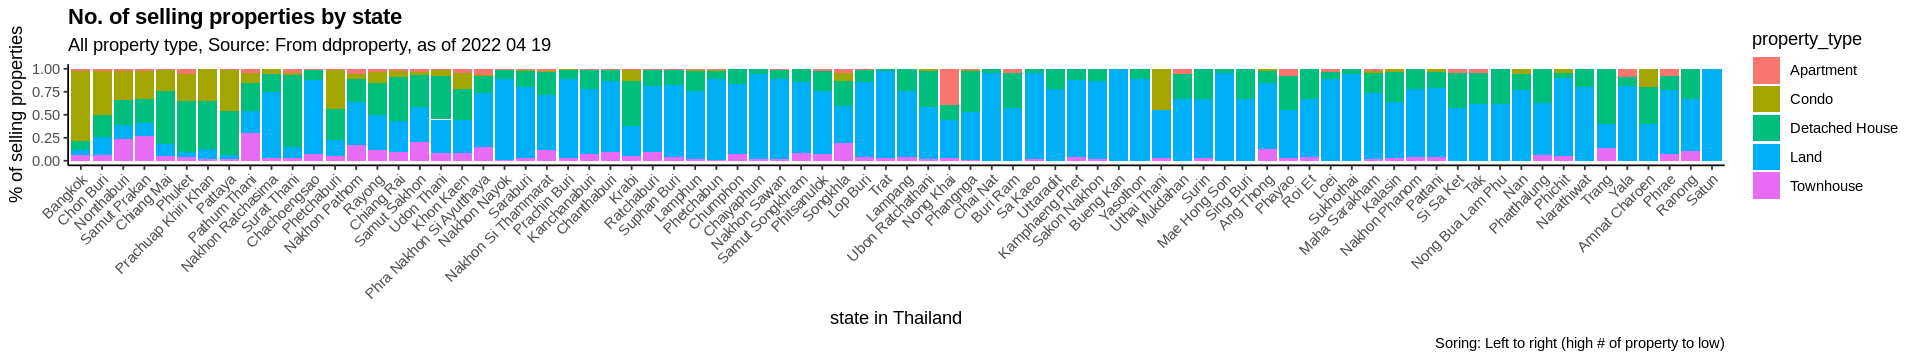

In [ ]:
## No. of selling property by state (excl. condo)
options(repr.plot.width = 16, repr.plot.height = 3, dpi = 600)

ggplot(d.by_State, mapping = aes(y = reorder(state, -total_count), x = total_count, fill = property_type)) +
  geom_col(position = "fill") +
  scale_x_continuous(labels = scales::comma) +
  coord_flip() +
  ##theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "No. of selling properties by state",
       x = "% of selling properties",
       y = "state in Thailand",
       subtitle = "All property type, Source: From ddproperty, as of 2022 04 19 ",
       caption = "Soring: Left to right (high # of property to low)")

## no. of selling property by state (excl. condo)

## Property type overview

### Data preparation

In [ ]:
## data preparation
d.by_prop_type <- data %>%
  group_by(property_type) %>%
  summarise(
    total_price = sum(price),
    total_count = sum(count),
  )

d.by_prop_type <- d.by_prop_type %>%
  mutate(prop_count = round(total_count/sum(total_count)*100, digits = 2)) %>%  ##calculate proportion by count of selling properties
  mutate(prop_price = round(total_price/sum(total_price)*100, digits = 2))

head(d.by_prop_type)

property_type,total_price,total_count,prop_count,prop_price
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Apartment,5.481402e+11,4553,2.06,5.43
Condo,1.358067e+12,129129,58.55,13.45
Detached House,2.860700e+12,42721,19.37,28.34
Land,5.189334e+12,25457,11.54,51.40
Townhouse,1.393585e+11,18697,8.48,1.38


### Pie charts (count & price)

In [ ]:
## supply overview pie
options(repr.plot.width = 6, repr.plot.height = 4, dpi = 600)

pie_count <- ggplot(d.by_prop_type, mapping = aes (x = " ", y = prop_count, fill = property_type)) +
  geom_col() +
  geom_text(aes(label = prop_count)) +
  coord_polar(theta = "y") +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)
                      ,limits = c(0,1)) +
  scale_fill_brewer(palette = "Set2") +

##theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "No. of selling property by property type",
       x = " ",
       subtitle = "Source: From ddproperty, as of 2022 04 19 ")

pie_price <- ggplot(d.by_prop_type, mapping = aes (x = " ", y = prop_price, fill = property_type)) +
  geom_col() +
  geom_text(aes(label = prop_price)) +
  coord_polar(theta = "y") +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)
                      ,limits = c(0,1)) +
  scale_fill_brewer(palette = "Set3") +


##theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "Total selling price by property type",
       x = " ",
       subtitle = "Source: From ddproperty, as of 2022 04 19 ")

print(pie_count)
print(pie_price)


### Column (count & price)

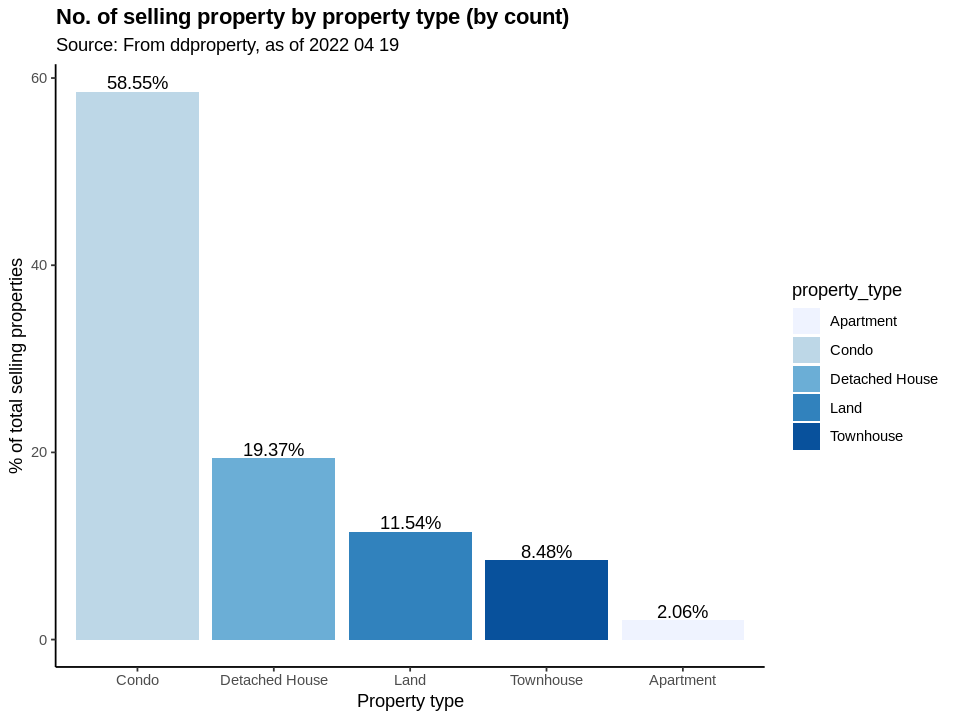

In [ ]:
#supply overview column - total count
options(repr.plot.width = 8, repr.plot.height = 6, dpi = 600)

 ggplot(d.by_prop_type, mapping = aes (x = reorder(property_type, - prop_count), y = prop_count, fill = property_type)) +
  geom_col(position = "Dodge") +
  geom_text(aes(label = paste0(prop_count, "%"), vjust = -0.2)) +
  scale_fill_brewer(palette = "Blues") +

##theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "No. of selling property by property type (by count)",
      y = "% of total selling properties",
      x = "Property type",
       subtitle = "Source: From ddproperty, as of 2022 04 19 ")

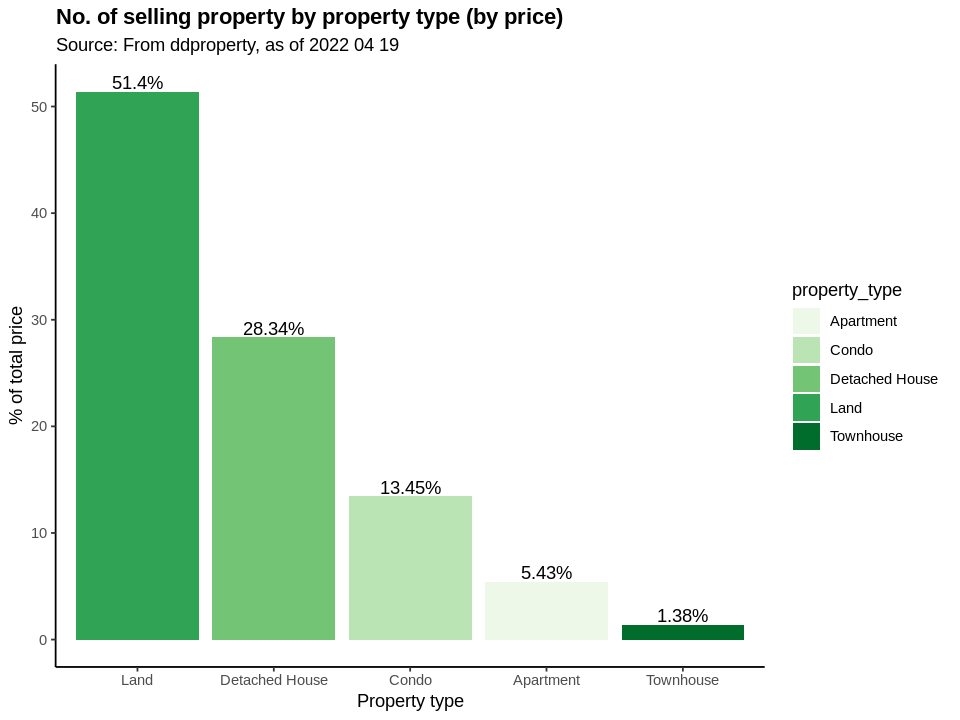

In [ ]:
#supply overview column - total sales
options(repr.plot.width = 8, repr.plot.height = 6, dpi = 600)

 ggplot(d.by_prop_type, mapping = aes (x = reorder(property_type, - prop_price), y = prop_price, fill = property_type)) +
  geom_col(position = "Dodge") +
  geom_text(aes(label = paste0(prop_price, "%"), vjust = -0.2)) +
   scale_fill_brewer(palette = "Greens") +

##theme and label
  theme_classic() +
  theme(plot.title = element_text(face = "bold"),
        element_text(family = "Noto sans")) +
  labs(title = "No. of selling property by property type (by price)",
      y = "% of total price",
      x = "Property type",
       subtitle = "Source: From ddproperty, as of 2022 04 19 ")

Further analysis
*   Aggregated data by state
*   Property price by state

